# Memory-based Collaborative Filtering 

In [17]:
# Data processing 
import numpy as np 
import pandas as pd
import scipy.stats

# Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity


### Get the data

In [22]:
# import rating
rating = pd.read_csv('ratings.csv')

#import movies
movies=pd.read_csv('movies.csv')

# import tags
tags=pd.read_csv('tags.csv')

In [19]:
rating.userId = rating.userId-1
rating.userId

0           0
1           0
2           0
3           0
4           0
         ... 
100831    609
100832    609
100833    609
100834    609
100835    609
Name: userId, Length: 100836, dtype: int64

In [9]:
# Get unique userId values and print the first 10
unique_user_ids = rating['userId'].unique()
print("First 10 unique userId values:")
print(unique_user_ids[:10])

min_user_id = rating['userId'].min()
max_user_id = rating['userId'].max()

print("Minimum userId:", min_user_id)
print("Maximum userId:", max_user_id)

First 10 unique userId values:
[ 1  2  3  4  5  6  7  8  9 10]
Minimum userId: 1
Maximum userId: 610


In [12]:
unique_movie_ids=rating["movieId"].unique()
print(unique_movie_ids[:10])

print(rating["movieId"].max())
print(rating["movieId"].min())

[  1   3   6  47  50  70 101 110 151 157]
193609
1


In [ ]:
# Check if userId values are ordered sequentially
sequential_order = rating['userId'].is_monotonic_increasing
print("UserIds are ordered sequentially:", sequential_order)

In [13]:
#checking if movieId values are sequentially ordered

rating["movieId"].is_monotonic_increasing

False

In [24]:
# Choose a specific userId (replace 1 with the desired userId)
selected_user_id = 1

# Filter ratings for the selected user
selected_user_ratings = rating[rating['userId'] == selected_user_id]

# Find maximum and minimum ratings for the selected user
max_rating = selected_user_ratings['rating'].max()
min_rating = selected_user_ratings['rating'].min()

print(f"Maximum rating given by user {selected_user_id}: {max_rating}")
print(f"Minimum rating given by user {selected_user_id}: {min_rating}")


Maximum rating given by user 1: 5.0
Minimum rating given by user 1: 1.0


In [ ]:
# Group by 'userId' and count the number of ratings for each user
user_ratings_count = rating.groupby('userId')['rating'].count()

# Find the maximum and minimum number of ratings by a single user
max_ratings_by_user = user_ratings_count.max()
min_ratings_by_user = user_ratings_count.min()

print(f"Maximum number of ratings by a single user: {max_ratings_by_user}")
print(f"Minimum number of ratings by a single user: {min_ratings_by_user}")

In [24]:
# Make the user ids go from 0...N-1

rating.userId = rating.userId-1
rating.userId

#create a mapping for movieids

unique_movie_ids=set(rating.movieId.values)
movie2idx={}
count=0
for movie_id in unique_movie_ids:
    movie2idx[movie_id]=count
    count+=1
    
#add them to the data frame

rating["movie_idx"]=rating.apply(lambda row: movie2idx[row.movieId],axis=1)
rating=rating.drop(columns=['timestamp'])
rating.to_csv('edited_rating.csv')


### User-user Collaborative Filtering

* The basic intuition of user-user is finding "users like me" since there are some movies I seen but others don't and vice versal
* The movies that those users have seen, that I have't seen, become my recommendations( if they are like me, i would like movies they have rated highly)
* user_user looks row-wise(each row is a vector)
* 2users are similar of their row vectors have small distance b/n them

#### Shrinking the data

* Full dataset is too large to perform an algorithm
* We need to select a subset of users and movies: which users and movies we should to choose
* need to choose users who rated the most movies
* movies who have been rated by the most users


In [31]:
from __future__ import print_function, division
from builtins import range, input


import pickle
import numpy as np
import pandas as pd
from collections import Counter


print("original dataframe size:", len(df))

N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies
print(f"number of users:{N}, number of movies:{M}")


#Counting the number of occurances of userId and movieId in the dataset  
user_ids_count = Counter(df.userId) 
movie_ids_count = Counter(df.movie_idx)
#print(f"number of users occurance:{user_ids_count}, number of movies occurance:{movie_ids_count}")
# number of users and movies we would like to keep
n = 10000
m = 2000

user_ids = [u for u, c in user_ids_count.most_common(n)]
movie_ids = [m for m, c in movie_ids_count.most_common(m)]

# make a copy, otherwise ids won't be overwritten
# extracting userId from user_ids(select* from dataframe where user_id in user_ids)
df_small = df[df.userId.isin(user_ids) & df.movie_idx.isin(movie_ids)].copy()

# need to remake user ids and movie ids since they are no longer sequential
new_user_id_map = {}
i = 0
for old in user_ids:
  new_user_id_map[old] = i
  i += 1
print("i:", i)

new_movie_id_map = {}
j = 0
for old in movie_ids:
  new_movie_id_map[old] = j
  j += 1
print("j:", j)

print("Setting new ids")
df_small.loc[:, 'userId'] = df_small.apply(lambda row: new_user_id_map[row.userId], axis=1)
df_small.loc[:, 'movie_idx'] = df_small.apply(lambda row: new_movie_id_map[row.movie_idx], axis=1)
# df_small.drop(columns=['userId', 'movie_idx'])
# df_small.rename(index=str, columns={'new_userId': 'userId', 'new_movie_idx': 'movie_idx'})
print("max user id:", df_small.userId.max())
print("max movie id:", df_small.movie_idx.max())

print("small dataframe size:", len(df_small))
df_small.to_csv('small_rating.csv', index=False)

original dataframe size: 100836
number of users:610, number of movies:9724
number of users occurance:Counter({413: 2698, 598: 2478, 473: 2108, 447: 1864, 273: 1346, 609: 1302, 67: 1260, 379: 1218, 605: 1115, 287: 1055, 248: 1046, 386: 1027, 181: 977, 306: 975, 602: 943, 297: 939, 176: 904, 317: 879, 231: 862, 479: 836, 607: 831, 599: 763, 482: 728, 589: 728, 104: 722, 18: 703, 304: 677, 488: 648, 110: 646, 437: 635, 216: 613, 139: 608, 476: 600, 554: 578, 90: 575, 27: 570, 218: 528, 533: 520, 88: 518, 63: 517, 225: 507, 560: 505, 17: 502, 524: 500, 56: 476, 380: 474, 367: 469, 508: 467, 468: 465, 559: 458, 461: 455, 291: 446, 20: 443, 596: 443, 41: 440, 159: 437, 293: 437, 579: 436, 595: 411, 201: 403, 274: 403, 516: 400, 44: 399, 155: 398, 513: 397, 390: 386, 566: 385, 356: 383, 102: 377, 338: 371, 61: 366, 198: 363, 124: 360, 50: 359, 131: 347, 65: 345, 312: 340, 199: 334, 220: 331, 5: 314, 452: 311, 49: 310, 424: 306, 427: 300, 572: 299, 351: 294, 83: 293, 121: 292, 381: 291, 355: 2

#### Table to Dictionary

* Given user "i", which movies "j" did they rate?
* Given movie "j", which users "i" have rated it?
* Given user "i" and movie "j", what is the rating?

* Solution use key>value lookup
* user2movie:key(userID)---value(series of moviesId w/c the user rated)
* key(userId and movieId)---value(rating)


In [32]:
from __future__ import print_function, division
from builtins import range, input


import pickle
from sklearn.utils import shuffle


df = pd.read_csv('small_rating.csv')

N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test

df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]

# a dictionary to tell us which users have rated which movies
user2movie = {}

# a dicationary to tell us which movies have been rated by which users
movie2user = {}

# a dictionary to look up ratings

usermovie2rating = {}
print("Calling: update_user2movie_and_movie2user")
count = 0
def update_user2movie_and_movie2user(row):
  global count #just for debuging purposes
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/cutoff))

  i = int(row.userId)
  j = int(row.movie_idx)
  if i not in user2movie:
    user2movie[i] = [j]
  else:
    user2movie[i].append(j)

  if j not in movie2user:
    movie2user[j] = [i]
  else:
    movie2user[j].append(i)

  usermovie2rating[(i,j)] = row.rating
df_train.apply(update_user2movie_and_movie2user, axis=1)

# test ratings dictionary
usermovie2rating_test = {}
print("Calling: update_usermovie2rating_test")
count = 0
def update_usermovie2rating_test(row):
  global count #used for debuging purposes
  count += 1
  if count % 100000 == 0:
    print("processed: %.3f" % (float(count)/len(df_test)))

  i = int(row.userId)
  j = int(row.movie_idx)
  usermovie2rating_test[(i,j)] = row.rating
df_test.apply(update_usermovie2rating_test, axis=1)

# note: these are not really JSONs
with open('user2movie.json', 'wb') as f:
  pickle.dump(user2movie, f)
# pickle can write and load any python file
with open('movie2user.json', 'wb') as f:
  pickle.dump(movie2user, f)

with open('usermovie2rating.json', 'wb') as f:
  pickle.dump(usermovie2rating, f)

with open('usermovie2rating_test.json', 'wb') as f:
  pickle.dump(usermovie2rating_test, f)

Calling: update_user2movie_and_movie2user
Calling: update_usermovie2rating_test


In [ ]:
from __future__ import print_function, division
from builtins import range, input


import pickle
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime
from sortedcontainers import SortedList

# load in the data/checks the existence of the json data
import os 
if not os.path.exists('user2movie.json') or \
   not os.path.exists('movie2user.json') or \
   not os.path.exists('usermovie2rating.json') or \
   not os.path.exists('usermovie2rating_test.json'):
  


 with open('user2movie.json', 'rb') as f:
  user2movie = pickle.load(f)

with open('movie2user.json', 'rb') as f:
  movie2user = pickle.load(f)

with open('usermovie2rating.json', 'rb') as f:
  usermovie2rating = pickle.load(f)

with open('usermovie2rating_test.json', 'rb') as f:
  usermovie2rating_test = pickle.load(f)


N = np.max(list(user2movie.keys())) + 1
# The test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)

if N > 10000:
  print("N =", N, "are you sure you want to continue?")
  print("Comment out these lines if so...")
  exit()


# To find the user similarities, you have to do O(N^2 * M) calculations!
# in the "real-world" you'd want to parallelize this
# note: we really only have to do half the calculations, since w_ij is symmetric
K = 25 # number of neighbors we'd like to consider
limit = 5 # number of common movies users must have in common in order to consider
#If two users don't have any movie/few movie in common then we don't need to calculate correlation
neighbors = [] # store neighbors in this list
averages = [] # each user's average rating for later use
deviations = [] # each user's deviation for later use
for i in range(N):
  #Find the 25 closest users to user i
  movies_i = user2movie[i]
  movies_i_set = set(movies_i)

  #Calculate avg and deviation
  ratings_i = { movie:usermovie2rating[(i, movie)] for movie in movies_i }
  avg_i = np.mean(list(ratings_i.values()))
  dev_i = { movie:(rating - avg_i) for movie, rating in ratings_i.items() }
  dev_i_values = np.array(list(dev_i.values()))
  sigma_i = np.sqrt(dev_i_values.dot(dev_i_values))

  #Save these for later use
  averages.append(avg_i)
  deviations.append(dev_i)

  sl = SortedList()
  for j in range(N):
    #Don't include yourself
    if j != i:
      movies_j = user2movie[j]
      movies_j_set = set(movies_j)
      common_movies = (movies_i_set & movies_j_set) # intersection
      if len(common_movies) > limit:
        # Calculate avg and deviation
        ratings_j = { movie:usermovie2rating[(j, movie)] for movie in movies_j }
        avg_j = np.mean(list(ratings_j.values()))
        dev_j = { movie:(rating - avg_j) for movie, rating in ratings_j.items() }
        dev_j_values = np.array(list(dev_j.values()))
        sigma_j = np.sqrt(dev_j_values.dot(dev_j_values))

        #Calculate correlation coefficient
        numerator = sum(dev_i[m]*dev_j[m] for m in common_movies)
        w_ij = numerator / (sigma_i * sigma_j)

        #Insert into sorted list and truncate
        # negate weight, because list is sorted ascending
        # maximum value (1) is "closest"
        sl.add((-w_ij, j))
        if len(sl) > K:
          del sl[-1]

  #Store the neighbors
  neighbors.append(sl)

  #Print out useful things
  if i % 1 == 0:
    print(i)


#Using neighbors, calculate train and test MSE

def predict(i, m):
  #Calculate the weighted sum of deviations
  numerator = 0
  denominator = 0
  for neg_w, j in neighbors[i]:
    #Remember, the weight is stored as its negative
    # so the negative of the negative weight is the positive weight
    try:
      numerator += -neg_w * deviations[j][m]
      denominator += abs(neg_w)
    except KeyError:
      #Neighbor may not have rated the same movie
      # don't want to do dictionary lookup twice
      # so just throw exception
      pass

  if denominator == 0:
    prediction = averages[i]
  else:
    prediction = numerator / denominator + averages[i]
  prediction = min(5, prediction)
  prediction = max(0.5, prediction) # min rating is 0.5
  return prediction


train_predictions = []
train_targets = []
for (i, m), target in usermovie2rating.items():
  #Calculate the prediction for this movie
  prediction = predict(i, m)

  #Save the prediction and target
  train_predictions.append(prediction)
  train_targets.append(target)

test_predictions = []
test_targets = []
#Same thing for test set
for (i, m), target in usermovie2rating_test.items():
  #Calculate the prediction for this movie
  prediction = predict(i, m)

  #Save the prediction and target
  test_predictions.append(prediction)
  test_targets.append(target)


#Calculate accuracy
def mse(p, t):
  p = np.array(p)
  t = np.array(t)
  return np.mean((p - t)**2)

print('train mse:', mse(train_predictions, train_targets))
print('test mse:', mse(test_predictions, test_targets))

### Item-Item Collaborative Filtering

* Instead of finding two users which are similar,let's try to find two products which are similar

* Two movies are similar if users given them similar ratings 
* looks column-wise
* 2items are similar of their column vectors have small distance b/n them
* The average rating for item j, where as in user-user it's the average rating for users
* If user i, like item j'and we also we that item j and j' are very similar then user i probably likes j too(wjj' is high)


* User-user CF: choose items for a user, b/c those items have been liked by similar users

* Item-item CF: choose items for a user, b/c this user has liked similar items in the past








In [ ]:
# https://udemy.com/recommender-systems
# https://deeplearningcourses.com/recommender-systems
from __future__ import print_function, division
from builtins import range, input
# Note: you may need to update your version of future
# sudo pip install -U future

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from datetime import datetime
from sortedcontainers import SortedList

# load in the data
import os
if not os.path.exists('user2movie.json') or \
   not os.path.exists('movie2user.json') or \
   not os.path.exists('usermovie2rating.json') or \
   not os.path.exists('usermovie2rating_test.json'):
   import preprocess2dict


with open('user2movie.json', 'rb') as f:
  user2movie = pickle.load(f)

with open('movie2user.json', 'rb') as f:
  movie2user = pickle.load(f)

with open('usermovie2rating.json', 'rb') as f:
  usermovie2rating = pickle.load(f)

with open('usermovie2rating_test.json', 'rb') as f:
  usermovie2rating_test = pickle.load(f)


N = np.max(list(user2movie.keys())) + 1
# the test set may contain movies the train set doesn't have data on
m1 = np.max(list(movie2user.keys()))
m2 = np.max([m for (u, m), r in usermovie2rating_test.items()])
M = max(m1, m2) + 1
print("N:", N, "M:", M)

if M > 2000:
  print("N =", N, "are you sure you want to continue?")
  print("Comment out these lines if so...")
  exit()


# to find the user similarities, you have to do O(M^2 * N) calculations!
# in the "real-world" you'd want to parallelize this
# note: we really only have to do half the calculations, since w_ij is symmetric
K = 20 # number of neighbors we'd like to consider
limit = 5 # number of common movies users must have in common in order to consider
neighbors = [] # store neighbors in this list
averages = [] # each item's average rating for later use
deviations = [] # each item's deviation for later use

for i in range(M):
  # find the K closest items to item i
  users_i = movie2user[i]
  users_i_set = set(users_i)

  # calculate avg and deviation
  ratings_i = { user:usermovie2rating[(user, i)] for user in users_i }
  avg_i = np.mean(list(ratings_i.values()))
  dev_i = { user:(rating - avg_i) for user, rating in ratings_i.items() }
  dev_i_values = np.array(list(dev_i.values()))
  sigma_i = np.sqrt(dev_i_values.dot(dev_i_values))

  # save these for later use
  averages.append(avg_i)
  deviations.append(dev_i)

  sl = SortedList()
  for j in range(M):
    # don't include yourself
    if j != i:
      users_j = movie2user[j]
      users_j_set = set(users_j)
      common_users = (users_i_set & users_j_set) # intersection
      if len(common_users) > limit:
        # calculate avg and deviation
        ratings_j = { user:usermovie2rating[(user, j)] for user in users_j }
        avg_j = np.mean(list(ratings_j.values()))
        dev_j = { user:(rating - avg_j) for user, rating in ratings_j.items() }
        dev_j_values = np.array(list(dev_j.values()))
        sigma_j = np.sqrt(dev_j_values.dot(dev_j_values))

        # calculate correlation coefficient
        numerator = sum(dev_i[m]*dev_j[m] for m in common_users)
        w_ij = numerator / (sigma_i * sigma_j)

        # insert into sorted list and truncate
        # negate weight, because list is sorted ascending
        # maximum value (1) is "closest"
        sl.add((-w_ij, j))
        if len(sl) > K:
          del sl[-1]

  # store the neighbors
  neighbors.append(sl)

  # print out useful things
  if i % 1 == 0:
    print(i)



# using neighbors, calculate train and test MSE

def predict(i, u):
  # calculate the weighted sum of deviations
  numerator = 0
  denominator = 0
  for neg_w, j in neighbors[i]:
    # remember, the weight is stored as its negative
    # so the negative of the negative weight is the positive weight
    try:
      numerator += -neg_w * deviations[j][u]
      denominator += abs(neg_w)
    except KeyError:
      # neighbor may not have been rated by the same user
      # don't want to do dictionary lookup twice
      # so just throw exception
      pass

  if denominator == 0:
    prediction = averages[i]
  else:
    prediction = numerator / denominator + averages[i]
  prediction = min(5, prediction)
  prediction = max(0.5, prediction) # min rating is 0.5
  return prediction



train_predictions = []
train_targets = []
for (u, m), target in usermovie2rating.items():
  # calculate the prediction for this movie
  prediction = predict(m, u)

  # save the prediction and target
  train_predictions.append(prediction)
  train_targets.append(target)

test_predictions = []
test_targets = []
# same thing for test set
for (u, m), target in usermovie2rating_test.items():
  # calculate the prediction for this movie
  prediction = predict(m, u)

  # save the prediction and target
  test_predictions.append(prediction)
  test_targets.append(target)


# calculate accuracy
def mse(p, t):
  p = np.array(p)
  t = np.array(t)
  return np.mean((p - t)**2)

print('train mse:', mse(train_predictions, train_targets))
print('test mse:', mse(test_predictions, test_targets))

### Exploratory Data Analysis(EDA)

In [14]:
rating.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


User with ID 1 gave a rating of 4.0 to the movie with ID 1, and the rating was recorded at the timestamp 964982703

In [4]:
rating.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [5]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [6]:
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


Both the dataset have one common column(movieId) which will help us to combine them together. Moreover, the  dataset doesn't have any missing value.

In [7]:
# The number of unique users
print("The ratings dataset has", rating['userId'].nunique(),"unique users")

# The number of movies
print("The rating dataset has", rating['movieId'].nunique(), "unique movies")

# The number of ratings
print("The rating dataset has", rating['rating'].nunique(), "unique movies")

# list of unique ratings

print("The unique rating are", sorted(rating['rating'].unique()))

The ratings dataset has 610 unique users
The rating dataset has 9724 unique movies
The rating dataset has 10 unique movies
The unique rating are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


610 unique users provide all the 10 ratings starting from 0.5 with 0.5 interval.

#### Merging the movies and ratings datasets

In [8]:
dataset = pd.merge(rating, movies, on='movieId', how="inner")
dataset

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
100831,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller
100832,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama
100833,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller
100834,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller


#### Basic statistics

In [9]:
dataset.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


In [10]:
mean_rating=dataset.groupby("title")['rating'].mean()
mean_rating

title
'71 (2014)                                   4.000000
'Hellboy': The Seeds of Creation (2004)      4.000000
'Round Midnight (1986)                       3.500000
'Salem's Lot (2004)                          5.000000
'Til There Was You (1997)                    4.000000
                                               ...   
eXistenZ (1999)                              3.863636
xXx (2002)                                   2.770833
xXx: State of the Union (2005)               2.000000
¡Three Amigos! (1986)                        3.134615
À nous la liberté (Freedom for Us) (1931)    1.000000
Name: rating, Length: 9719, dtype: float64

Checking the mean of all the movies is very important

In [11]:
number_of_rating=dataset.groupby("title")['rating'].count()
number_of_rating

title
'71 (2014)                                    1
'Hellboy': The Seeds of Creation (2004)       1
'Round Midnight (1986)                        2
'Salem's Lot (2004)                           1
'Til There Was You (1997)                     2
                                             ..
eXistenZ (1999)                              22
xXx (2002)                                   24
xXx: State of the Union (2005)                5
¡Three Amigos! (1986)                        26
À nous la liberté (Freedom for Us) (1931)     1
Name: rating, Length: 9719, dtype: int64

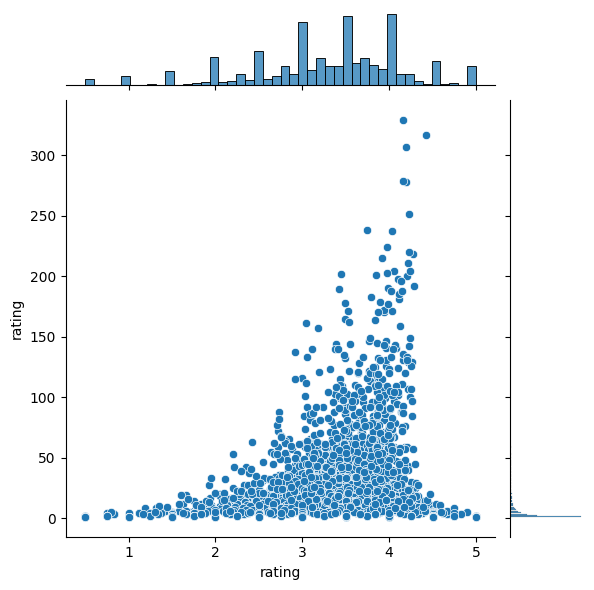

In [12]:
#Joint plot
sns.jointplot(x=mean_rating, y=number_of_rating)
plt.show()

In [13]:
#The movies with highest number of user rated
dataset["title"].value_counts()

title
Forrest Gump (1994)                 329
Shawshank Redemption, The (1994)    317
Pulp Fiction (1994)                 307
Silence of the Lambs, The (1991)    279
Matrix, The (1999)                  278
                                   ... 
Sex, Drugs & Taxation (2013)          1
Extraordinary Tales (2015)            1
Tomorrow (2015)                       1
Embrace of the Serpent (2016)         1
31 (2016)                             1
Name: count, Length: 9719, dtype: int64

### User based collaborative filtering 

Every dataset should be filtered as every ratings given by the user wont be important.

* To qualify a movie, minimum of 30 users should have rated that movie
* To qualify a user, minimum of 20 movies should have been rated by that user

In [15]:
filtered_data = dataset[dataset.groupby("movieId")["movieId"].transform("size")>30]
filtered_data

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
84781,495,1172,5.0,1458636678,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
84782,587,1172,5.0,953137693,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
84783,597,1172,5.0,941639635,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
84784,603,1172,1.0,953927813,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


In [16]:
filtered_data = filtered_data[filtered_data.groupby("userId")["userId"].transform("size")>20]
filtered_data

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
...,...,...,...,...,...,...
84781,495,1172,5.0,1458636678,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
84782,587,1172,5.0,953137693,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
84783,597,1172,5.0,941639635,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama
84784,603,1172,1.0,953927813,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama


#### Create a user-movie matrix

In [20]:
user_movie=filtered_data.pivot_table(index="userId", columns = "title", values="rating")
user_movie # The rows of the matrix are users and the columns are movies and the values are 
# the value of the matrix is the user rating of the movie if there is a rating unless NaN  

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",50 First Dates (2004),...,X-Men: First Class (2011),X-Men: The Last Stand (2006),X2: X-Men United (2003),Yes Man (2008),You've Got Mail (1998),Young Frankenstein (1974),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3.5,3.5,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,3.0,3.5,5.0,NaN,NaN,...,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN


There are a lot of NaN as every movie is not rated by the user. Each user will give different ratings 

#### Normalize the rating

In [23]:
matrix_norm =  user_movie.subtract(user_movie.mean(axis=1), axis=0)
matrix_norm

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",50 First Dates (2004),...,X-Men: First Class (2011),X-Men: The Last Stand (2006),X2: X-Men United (2003),Yes Man (2008),You've Got Mail (1998),Young Frankenstein (1974),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,0.598726,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,1.568966,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,0.508621,NaN,NaN,NaN,NaN,...,NaN,0.508621,0.508621,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,NaN,NaN,NaN,NaN,NaN,1.336088,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-0.163912,-0.163912,NaN,NaN,NaN,NaN
607,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
608,NaN,NaN,NaN,NaN,NaN,-0.339248,0.160752,1.660752,NaN,NaN,...,NaN,0.660752,0.660752,NaN,NaN,NaN,NaN,NaN,-0.339248,NaN


Not every movie is rated by every user

In [24]:
matrix_filled = matrix_norm.fillna(0)
matrix_filled

title,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",50 First Dates (2004),...,X-Men: First Class (2011),X-Men: The Last Stand (2006),X2: X-Men United (2003),Yes Man (2008),You've Got Mail (1998),Young Frankenstein (1974),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.598726,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.0,0.0,0.0,1.568966,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.0,0.0,0.0,0.000000,0.508621,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.508621,0.508621,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.0,0.0,0.0,0.000000,1.336088,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,-0.163912,-0.163912,0.000000,0.000000,0.000000,0.000000
607,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
608,0.000000,0.0,0.0,0.0,0.000000,-0.339248,0.160752,1.660752,0.000000,0.000000,...,0.000000,0.660752,0.660752,0.0,0.000000,0.000000,0.000000,0.000000,-0.339248,0.000000


#### Identify similar users

In [25]:
user_similarity = cosine_similarity(matrix_filled)
user_similarity

array([[ 1.        ,  0.07540701,  0.023582  , ...,  0.10103169,
        -0.03937749,  0.00750447],
       [ 0.07540701,  1.        , -0.05764491, ..., -0.05676804,
        -0.01870617,  0.00837167],
       [ 0.023582  , -0.05764491,  1.        , ..., -0.00202104,
         0.13897674,  0.00446405],
       ...,
       [ 0.10103169, -0.05676804, -0.00202104, ...,  1.        ,
         0.0692989 ,  0.01442518],
       [-0.03937749, -0.01870617,  0.13897674, ...,  0.0692989 ,
         1.        , -0.04545917],
       [ 0.00750447,  0.00837167,  0.00446405, ...,  0.01442518,
        -0.04545917,  1.        ]])

In [28]:
# creating data frame
user_simi_df = pd.DataFrame(user_similarity, columns = matrix_filled.index.values, index=matrix_filled.index.values)
user_simi_df 

,1,4,5,6,7,8,10,11,12,13,...,601,602,603,604,605,606,607,608,609,610
1,1.000000,0.075407,0.023582,-0.081810,-0.016298,0.057089,-0.009940,-0.072053,0.018814,0.073897,...,0.017946,-0.025844,-0.006501,-0.050298,-0.055527,0.025577,0.027854,0.101032,-0.039377,0.007504
4,0.075407,1.000000,-0.057645,0.030191,0.095866,0.003752,0.073975,0.088810,0.008313,-0.080612,...,-0.045376,0.071026,0.022251,-0.016055,0.075272,0.027440,0.020824,-0.056768,-0.018706,0.008372
5,0.023582,-0.057645,1.000000,0.024429,0.012980,0.008805,-0.044905,0.000026,0.073050,0.018252,...,0.020914,0.023732,0.035821,0.019805,-0.066475,0.037128,0.041645,-0.002021,0.138977,0.004464
6,-0.081810,0.030191,0.024429,1.000000,-0.008893,-0.107631,0.042062,0.117564,-0.001825,0.001748,...,-0.027100,-0.034224,-0.027633,-0.076345,0.012938,-0.041489,0.085165,-0.004284,0.077778,0.002108
7,-0.016298,0.095866,0.012980,-0.008893,1.000000,0.031483,-0.011266,0.020957,0.000243,-0.024857,...,-0.064038,0.045656,0.082597,0.026273,0.092507,0.054013,0.054463,0.013983,0.017463,0.096231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.025577,0.027440,0.037128,-0.041489,0.054013,0.035398,-0.066436,0.053622,-0.030575,0.022093,...,0.078779,0.031723,0.138507,0.109072,0.029608,1.000000,0.009283,0.113553,0.067731,0.173142
607,0.027854,0.020824,0.041645,0.085165,0.054463,0.059963,-0.029116,0.092472,-0.010656,-0.012823,...,0.055755,0.060952,0.071785,-0.010852,-0.040835,0.009283,1.000000,0.053641,0.024636,0.022459
608,0.101032,-0.056768,-0.002021,-0.004284,0.013983,0.101386,-0.080346,0.077358,-0.019929,0.093814,...,0.092625,0.086135,0.039096,0.032651,-0.014994,0.113553,0.053641,1.000000,0.069299,0.014425
609,-0.039377,-0.018706,0.138977,0.077778,0.017463,0.091401,-0.053912,0.055143,0.000000,0.000000,...,0.055148,0.080016,0.013669,0.140428,-0.094531,0.067731,0.024636,0.069299,1.000000,-0.045459


In [29]:
# pick user id
picked_userId = 6

# remove the picked user id from candidate list
user_simi_df.drop(index=picked_userId, inplace=True)
user_simi_df

,1,4,5,6,7,8,10,11,12,13,...,601,602,603,604,605,606,607,608,609,610
1,1.000000,0.075407,0.023582,-0.081810,-0.016298,0.057089,-0.009940,-0.072053,0.018814,0.073897,...,0.017946,-0.025844,-0.006501,-0.050298,-0.055527,0.025577,0.027854,0.101032,-0.039377,0.007504
4,0.075407,1.000000,-0.057645,0.030191,0.095866,0.003752,0.073975,0.088810,0.008313,-0.080612,...,-0.045376,0.071026,0.022251,-0.016055,0.075272,0.027440,0.020824,-0.056768,-0.018706,0.008372
5,0.023582,-0.057645,1.000000,0.024429,0.012980,0.008805,-0.044905,0.000026,0.073050,0.018252,...,0.020914,0.023732,0.035821,0.019805,-0.066475,0.037128,0.041645,-0.002021,0.138977,0.004464
7,-0.016298,0.095866,0.012980,-0.008893,1.000000,0.031483,-0.011266,0.020957,0.000243,-0.024857,...,-0.064038,0.045656,0.082597,0.026273,0.092507,0.054013,0.054463,0.013983,0.017463,0.096231
8,0.057089,0.003752,0.008805,-0.107631,0.031483,1.000000,-0.017268,0.047679,-0.043154,0.034455,...,0.075574,0.139240,0.042724,0.217300,-0.027827,0.035398,0.059963,0.101386,0.091401,0.023548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.025577,0.027440,0.037128,-0.041489,0.054013,0.035398,-0.066436,0.053622,-0.030575,0.022093,...,0.078779,0.031723,0.138507,0.109072,0.029608,1.000000,0.009283,0.113553,0.067731,0.173142
607,0.027854,0.020824,0.041645,0.085165,0.054463,0.059963,-0.029116,0.092472,-0.010656,-0.012823,...,0.055755,0.060952,0.071785,-0.010852,-0.040835,0.009283,1.000000,0.053641,0.024636,0.022459
608,0.101032,-0.056768,-0.002021,-0.004284,0.013983,0.101386,-0.080346,0.077358,-0.019929,0.093814,...,0.092625,0.086135,0.039096,0.032651,-0.014994,0.113553,0.053641,1.000000,0.069299,0.014425
609,-0.039377,-0.018706,0.138977,0.077778,0.017463,0.091401,-0.053912,0.055143,0.000000,0.000000,...,0.055148,0.080016,0.013669,0.140428,-0.094531,0.067731,0.024636,0.069299,1.000000,-0.045459


The user similarity varies from -1 to 1 which -1 indicates highly dissimilar whereas 1 highly similar

In [34]:
# number of similar users
n=5
# user similarity threshold
user_similarity_threshold = 0.1 # meaning the user must have an adjusted cosine similarity of atleast 0.1 to be considered as similar users

# get top similar users
similar_users =user_simi_df[user_simi_df[picked_userId]> user_similarity_threshold][picked_userId].sort_values(ascending=False)[:n]
print(f"The similar users for user {picked_userId} are", similar_users)

The similar users for user 6 are 181    0.301042
126    0.299649
411    0.262724
470    0.259768
584    0.251712
Name: 6, dtype: float64


In [35]:
# Movies that the target user has watched
picked_userId_watched = user_movie[user_movie.index == picked_userId].dropna(axis=1,how="all")
picked_userId_watched # Select the movie the chosen user has already watched/only the picked row is selected

title,Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Aladdin (1992),"American President, The (1995)",Apollo 13 (1995),"Aristocats, The (1970)",Babe (1995),Bad Boys (1995),Batman (1989),...,Tommy Boy (1995),True Lies (1994),"Truth About Cats & Dogs, The (1996)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),"Usual Suspects, The (1995)",Waterworld (1995),What's Eating Gilbert Grape (1993),While You Were Sleeping (1995),Willy Wonka & the Chocolate Factory (1971)
userId,,,,,,,,,,,,,,,,,,,,,
6,3.0,2.0,3.0,5.0,4.0,4.0,5.0,4.0,4.0,3.0,...,5.0,4.0,4.0,4.0,5.0,1.0,3.0,5.0,4.0,3.0


This indicates the user has rated or watched 137 movies

In [36]:
#movies that similar users have watched. remove movies that none of the similar users have watched

similar_user_movies= user_movie[user_movie.index.isin(similar_users.index)].dropna(axis=1, how="all")
similar_user_movies

title,Ace Ventura: Pet Detective (1994),Ace Ventura: When Nature Calls (1995),Addams Family Values (1993),Aladdin (1992),"American President, The (1995)",Apollo 13 (1995),Babe (1995),Bad Boys (1995),Batman (1989),Batman Forever (1995),...,Toy Story (1995),True Lies (1994),"Truth About Cats & Dogs, The (1996)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),"Usual Suspects, The (1995)",Waterworld (1995),What's Eating Gilbert Grape (1993),While You Were Sleeping (1995),Willy Wonka & the Chocolate Factory (1971)
userId,,,,,,,,,,,,,,,,,,,,,
126,1.0,NaN,2.0,3.0,NaN,4.0,3.0,NaN,3.0,4.0,...,NaN,5.0,NaN,NaN,NaN,NaN,2.0,NaN,3.0,NaN
181,3.0,NaN,NaN,4.0,5.0,NaN,5.0,2.0,2.0,NaN,...,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,3.0
411,2.0,NaN,NaN,NaN,4.0,5.0,4.0,NaN,3.0,NaN,...,5.0,4.0,3.0,NaN,NaN,3.0,4.0,NaN,3.0,NaN
470,3.0,3.0,4.0,3.0,NaN,3.0,4.0,NaN,3.0,4.0,...,4.0,5.0,NaN,3.0,4.0,3.0,3.0,NaN,4.0,4.0
584,1.0,3.0,3.0,4.0,NaN,5.0,3.0,NaN,3.0,3.0,...,5.0,5.0,NaN,NaN,5.0,NaN,4.0,3.0,4.0,NaN


In [37]:
# remove the watched movie from the movie list
#removing the selected movie =6 because we don't recommend that movie again

similar_user_movies.drop(picked_userId_watched.columns, axis=1, inplace=True, errors='ignore')
similar_user_movies

title,Beverly Hills Cop III (1994),"Brady Bunch Movie, The (1995)",Carlito's Way (1993),Clerks (1994),Clueless (1995),Demolition Man (1993),Dragonheart (1996),Ed Wood (1994),Eraser (1996),Home Alone (1990),...,Mission: Impossible (1996),"Nightmare Before Christmas, The (1993)","Nutty Professor, The (1996)",Pocahontas (1995),Quiz Show (1994),"River Wild, The (1994)",Searching for Bobby Fischer (1993),Showgirls (1995),Taxi Driver (1976),Toy Story (1995)
userId,,,,,,,,,,,,,,,,,,,,,
126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
181,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
411,NaN,3.0,3.0,4.0,NaN,3.0,NaN,3.0,NaN,4.0,...,5.0,4.0,NaN,NaN,3.0,4.0,3.0,NaN,4.0,5.0
470,3.0,NaN,NaN,NaN,3.0,NaN,3.0,NaN,3.0,NaN,...,3.0,NaN,3.0,NaN,4.0,NaN,NaN,NaN,NaN,4.0
584,4.0,3.0,NaN,NaN,1.0,5.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,5.0,3.0,NaN,NaN,1.0,NaN,5.0


### Recommending movies

In [45]:
item_score = {}

for i in similar_user_movies.columns:
    movie_rating = similar_user_movies[i]
    
    total = 0
    count = 0
    
    for u in similar_users.index:
        if pd.notna(movie_rating[u]):
            score = similar_users[u] * movie_rating[u]
            total += score
            count += 1
    
    # Check if count is greater than zero to avoid division by zero
    if count > 0:
        item_score[i] = total / count
    else:
        item_score[i] = 0

item_score = pd.DataFrame(list(item_score.items()), columns=["movie", "movie_score"])
ranked_item_score = item_score.sort_values(by="movie_score", ascending=False)
m = 5
top_movies = ranked_item_score.head(m)
top_movies


,movie,movie_score
18,Pocahontas (1995),1.258560
24,Toy Story (1995),1.203751
23,Taxi Driver (1976),1.050898
3,Clerks (1994),1.050898
20,"River Wild, The (1994)",1.050898


These are the top five movies that will be recommended to user 6.

### Item based Collaborative Filtering

#### Create user-movie matrix

In [47]:
user_movie_2 = filtered_data.pivot_table(index="title", columns="userId", values="rating")
user_movie_2

userId,1,4,5,6,7,8,10,11,12,13,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,3.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (One Hundred and One Dalmatians) (1961),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Young Frankenstein (1974),5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,5.0,NaN,NaN,3.5,NaN,NaN,NaN,NaN
Zodiac (2007),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
Zombieland (2009),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5


In [51]:
matrix_norm_2=user_movie_2.subtract(user_movie_2.mean(axis=1),axis=0)
matrix_norm_2.head()

userId,1,4,5,6,7,8,10,11,12,13,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.1375
10 Things I Hate About You (1999),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.510204,NaN,...,NaN,NaN,-0.489796,NaN,1.510204,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (1996),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.976190,NaN,-0.023810,NaN,NaN,NaN,NaN,NaN
101 Dalmatians (One Hundred and One Dalmatians) (1961),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12 Angry Men (1957),NaN,0.787037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.787037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
matrix_filled_2= matrix_norm_2.fillna(0)
matrix_filled_2.head()

userId,1,4,5,6,7,8,10,11,12,13,...,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,
(500) Days of Summer (2009),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,-0.1375
10 Things I Hate About You (1999),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.510204,0.0,...,0.000000,0.0,-0.489796,0.0,1.510204,0.0,0.0,0.0,0.0,0.0000
101 Dalmatians (1996),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.976190,0.0,-0.023810,0.0,0.0,0.0,0.0,0.0000
101 Dalmatians (One Hundred and One Dalmatians) (1961),0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000
12 Angry Men (1957),0.0,0.787037,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.787037,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0000


#### Calculate item similarity

In [53]:
item_similarity_2 = cosine_similarity(matrix_filled_2)
item_similarity_2

array([[ 1.        ,  0.06546267,  0.04694232, ..., -0.01938697,
         0.02144164,  0.00687524],
       [ 0.06546267,  1.        ,  0.02196772, ...,  0.0409319 ,
        -0.03256453, -0.06169637],
       [ 0.04694232,  0.02196772,  1.        , ..., -0.0508725 ,
         0.02735599,  0.14952461],
       ...,
       [-0.01938697,  0.0409319 , -0.0508725 , ...,  1.        ,
        -0.03668144,  0.03963766],
       [ 0.02144164, -0.03256453,  0.02735599, ..., -0.03668144,
         1.        ,  0.01085914],
       [ 0.00687524, -0.06169637,  0.14952461, ...,  0.03963766,
         0.01085914,  1.        ]])

In [55]:
item_simi_df = pd.DataFrame(item_similarity_2, columns=matrix_filled_2.index.values, index=matrix_filled_2.index.values)
item_simi_df.head()

,(500) Days of Summer (2009),10 Things I Hate About You (1999),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),12 Angry Men (1957),2001: A Space Odyssey (1968),28 Days Later (2002),300 (2007),"40-Year-Old Virgin, The (2005)",50 First Dates (2004),...,X-Men: First Class (2011),X-Men: The Last Stand (2006),X2: X-Men United (2003),Yes Man (2008),You've Got Mail (1998),Young Frankenstein (1974),Zodiac (2007),Zombieland (2009),Zoolander (2001),Zootopia (2016)
(500) Days of Summer (2009),1.000000,0.065463,0.046942,0.028027,0.038293,0.049850,0.251753,0.184953,0.025518,0.164446,...,0.132133,0.118501,0.053725,0.143745,0.164399,0.092706,0.390399,-0.019387,0.021442,0.006875
10 Things I Hate About You (1999),0.065463,1.000000,0.021968,0.012313,-0.014529,-0.061747,0.016899,0.126651,0.029576,0.233004,...,0.046142,0.018536,-0.002810,-0.028829,0.297110,0.020817,0.070585,0.040932,-0.032565,-0.061696
101 Dalmatians (1996),0.046942,0.021968,1.000000,0.007410,0.019252,0.064931,-0.028695,0.089117,0.047074,0.052682,...,0.038190,0.014638,-0.008228,0.015168,-0.055180,0.065962,0.003138,-0.050873,0.027356,0.149525
101 Dalmatians (One Hundred and One Dalmatians) (1961),0.028027,0.012313,0.007410,1.000000,0.002556,0.031982,0.028462,-0.060418,-0.055696,0.085642,...,-0.021211,0.050001,0.015731,0.026795,0.028298,0.056758,0.017078,0.097188,0.015341,0.073677
12 Angry Men (1957),0.038293,-0.014529,0.019252,0.002556,1.000000,0.016218,-0.010778,-0.072797,0.008974,-0.028341,...,0.016997,0.002373,-0.131881,0.046524,0.000659,0.026527,0.068169,0.019268,0.026054,-0.024458


#### Predict a user's rating for one movie

In [56]:
#pick a user id 

picked_userId=6

#movies that the target user has watched
picked_userId_watched=pd.DataFrame(matrix_norm_2[picked_userId].dropna(axis=0, how="all")\
                                  .sort_values(ascending=False))\
                                  .reset_index()\
                                  .rename(columns={6:"rating"})
picked_userId_watched.head()


,title,rating
0,City Slickers II: The Legend of Curly's Gold (...,2.342593
1,Congo (1995),2.122807
2,Father of the Bride Part II (1995),1.978261
3,First Knight (1995),1.875000
4,Miracle on 34th Street (1994),1.805556


In [57]:
#pick an unwanted movie

picked_movie = "101 Dalmatians (1996)"

#similarity score of the movie 101
picked_movie_similarity_score=item_simi_df[[picked_movie]].reset_index().rename(columns={"index":"title","101 Dalmatians (1996)":"similarity_score"})
picked_movie_similarity_score

,title,similarity_score
0,(500) Days of Summer (2009),0.046942
1,10 Things I Hate About You (1999),0.021968
2,101 Dalmatians (1996),1.000000
3,101 Dalmatians (One Hundred and One Dalmatians...,0.007410
4,12 Angry Men (1957),0.019252
...,...,...
855,Young Frankenstein (1974),0.065962
856,Zodiac (2007),0.003138
857,Zombieland (2009),-0.050873
858,Zoolander (2001),0.027356


In [64]:
# rank similarities between the movie user 6 rated and 101 dalmatians
picked_userid_watched_similarity = pd.merge(left=picked_userId_watched,
                                           right=picked_movie_similarity_score,
                                            on="title",
                                            how="inner")\
                             .sort_values("similarity_score", ascending=False)[:5]
picked_userid_watched_similarity

,title,rating,similarity_score
39,"Santa Clause, The (1994)",0.793750,0.257886
59,"Birdcage, The (1996)",0.481707,0.208557
105,Pinocchio (1940),-0.457627,0.201446
82,Last Action Hero (1993),0.057692,0.186644
4,Miracle on 34th Street (1994),1.805556,0.156419


In [67]:
# calculate the predicted rating using weighted avg of similarity scores and ratings from user 6
predicted_rating = round(np.average(picked_userid_watched_similarity["rating"],
                                   weights=picked_userid_watched_similarity["similarity_score"]),5)
print(f"The predicted rating for {picked_movie} by user {picked_userId} is {predicted_rating}")

The predicted rating for 101 Dalmatians (1996) by user 6 is 0.50068


### Recommending movie

* Create a list of movies that the target user has not watched before
* Loop through the unwatched movie list and create predicted scores for each movie
* Rank the predicted score of unwanted movies for high to low
* Select the top K movies as the recommendations for each target user

In [70]:
def item_based_rec(picked_userId, no_of_similar_items, number_of_rec):
    import operator
    #movies that the target user has not watched 
    picked_userId_unwanted=pd.DataFrame(matrix_norm_2[picked_userId].isna()).reset_index()
    
    picked_userId_unwanted=picked_userId_unwanted[picked_userId_unwanted[picked_userId]==True]["title"].values.tolist()
    
    # movies that the target user has watched 
    picked_userId_watched=pd.DataFrame(matrix_norm_2[picked_userId].dropna(axis=0, how="all")\
                                      .sort_values(ascending=False))\
                                      .reset_index()\
                                      .rename(columns={picked_userId:"rating"})
    #dictionary to save the unwanted movie and predicted pair rating
    rating_prediction={}
    
    #loop through unwatched movies
    for picked_movie in picked_userId_unwanted:
        picked_movie_similarity_score=item_simi_df[[picked_movie]].reset_index().rename(
        columns={"index":"title", picked_movie:"similarity_score"})
        
        picked_userid_watched_similarity = pd.merge(left=picked_userId_watched,
                                           right=picked_movie_similarity_score,
                                            on="title",
                                            how="inner")\
                             .sort_values("similarity_score", ascending=False)[:no_of_similar_items]
        
        predicted_rating = round(np.average(picked_userid_watched_similarity["rating"],
                                   weights=picked_userid_watched_similarity["similarity_score"]),5)
        rating_prediction[picked_movie]=predicted_rating
        
    return sorted(rating_prediction.items(), key=operator.itemgetter(1), reverse=True)[:number_of_rec]

In [71]:
recommendation_movies= item_based_rec(picked_userId=6, no_of_similar_items=5,number_of_rec=3)
recommendation_movies

[("Knight's Tale, A (2001)", 1.53447),
 ('Home Alone (1990)', 1.52471),
 ('Jerry Maguire (1996)', 1.36224)]

### Model based Collaborative Filtering 

#### SVD

In [76]:
from scipy.sparse.linalg import svds

U, sigma, Vt =svds(matrix_filled,k=12)
U.shape, Vt.shape, sigma=np.diag(sigma)

K specifies the number of latent factors that affects the dimensionality of the matrix 

In [ ]:
all_user_predicted_ratings= np.dot(np.dot(U, sigma),Vt)

#### Making recommendation

In [ ]:
def recommend(user_id, k):
    na_indices= matrix_norm.loc(user_id).isna()
    row_number = matrix_norm.index.get_loc(user_id)
    rating_vector=all_user_predicted_ratings(row_number)
    n=len(rating_vector)
    rating_2bsorted=[(rating_vector[i],i) for i in range(n)]
    rating_sorted=sorted(rating_2bsorted, reverse=True)
    
    result = []
    i=0
    while(k>0) and (i<n):
        real_index=rating_sorted[i][1]
        if(na_indices[real_index]):
            result.append(rating_sorted[i])
            k-=1
        i+=1
    return result

In [ ]:
recommend(325,5)

In [ ]:
def suggest_movies(user_id, k):
    rating_recommend=recommend(user_id, k)
    for rating, ind in rating_recommend:
        movie_name=matrix_filled.columns[ind+1]
        print("movie name:'{}'with a rating of {:0.2f}".format(movie_name, rating) )